In [348]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluation

In [349]:
from scipy.stats import friedmanchisquare,rankdata,f
import scikit_posthocs as sp
import numpy as np
import Orange 
import pandas as pd

In [350]:
def to_latex(aggregated, aggregated_std, index_name='', caption='', label=''):
    aggregated = aggregated.replace('_','\_')
    aggregated_std = aggregated_std.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+' & '.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i, row in aggregated.iterrows():
        row_std = aggregated_std.loc[i]
        max_value = row.max()  # Find the maximum value in the row
        rowstring = []
        for r, r_std in zip(row, row_std):
            value_string = "{:0.2f}".format(r) + ' $\pm$ ' + "{:0.2f}".format(r_std)
            if r == max_value:  # Check if the value is the maximum in the row
                value_string = '\\textbf{' + value_string + '}'
            rowstring.append(value_string)
        print(str(i) + ' & ' + ' & '.join(rowstring) + '\\\\ \\hline')
    print('\\end{tabularx}\n\\end{table}')


In [351]:
def to_latex_nostd(aggregated, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        rowstring = []
        for r in row:
            rowstring.append("{:0.2f}".format(r))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

## Real datasets description

In [352]:
import os
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.datasets
import openml
import re
import warnings
warnings.filterwarnings('ignore')


data_characteristics=[]
synthetic=False

nf = 4
SYNTH_BREAK=50
i=1
target='class'




    

if synthetic: 
    for nf in range(4,SYNTH_BREAK):
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=250*int(nf), n_features=nf+4, 
                                              n_informative=int(nf/2), n_redundant=int(nf/4), n_repeated=0, n_clusters_per_class=int(nf/2),
                                              n_classes=2)
        features = [f'f_{i}' for i in range(0,X.shape[1])]
        categorical_indicator=[False]*len(features)
        df = pd.DataFrame(X, columns=features)
        df[target] = y
        num_and_cat = f'n_samples={250*int(nf)};n_features={nf+4};n_informative={int(nf/2)};n_redundant={int(nf/4)};n_classes={2};n_clusters={int(nf/2)}'
        directory='synthetic'
        data_characteristics.append(['synthetic_'+str(i),df.shape[0], df.shape[1]-1, int(nf/2),int(nf/4),int(nf/2),sum(y)/len(y)])
        i+=1
else:
    for use_suite in [True, False]:
        if not use_suite:
            all_datasets = openml.datasets.list_datasets(output_format='dataframe')
            classification_datasets = all_datasets[(all_datasets['NumberOfClasses']>1) & (all_datasets['NumberOfInstances']>500) & (all_datasets['NumberOfInstances']< 4000)& (all_datasets['NumberOfFeatures'] < 20)].drop_duplicates(subset=['name'])
            tasks = classification_datasets['did']
        else:
            suite = openml.study.get_suite(99)
            print(suite)
            tasks = suite.tasks
        for task_id in tasks:
    
            if use_suite:
                task = openml.tasks.get_task(task_id)
                num_and_cat = task.get_dataset().name
            else:
                num_and_cat= classification_datasets[classification_datasets['did'] == task_id]['name'].values[0]
                
            
            #if num_and_cat in  ['','FOREX_eurpln-day-Close']: #We have large number of examples in evaluaiton for this datasets.
            #    continue
            
            if True:#try:          
                if use_suite:
                    split = task.get_train_test_split_indices()
                    data,y= task.get_X_and_y()
                    Xtrain = data[split.train]
                    ytrain = y[split.train]
                    
                    Xtest= data[split.test]
                    ytest = y[split.test]
                    features = [f'f_{i}' for i in range(0,data.shape[1])]
    
                    df = pd.DataFrame(np.vstack((Xtrain, Xtest)), columns=features)
                    df[target] = np.concatenate((ytrain,ytest))        
                else:
                    try:
                        dataset = openml.datasets.get_dataset(task_id)
                        X, y, categorical_indicator, features = dataset.get_data(target=dataset.default_target_attribute)
                        features = [re.sub(r'[^\w]', '_', s) for s in features]
                        X.columns=features
                        le = LabelEncoder ()
                        y = le.fit_transform(y)
                        for col, is_categorical in zip(X.columns, categorical_indicator):
                            if is_categorical:
                                X[col] = le.fit_transform(X[col])
            
                        if 'Timestamp' in X.columns:
                            continue
                            
                        Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.33)
                        df=X
                        df[target] = y                    
                    except:
                        continue
                vc = df[target].value_counts()
                data_characteristics.append([num_and_cat,df.shape[0], df.shape[1]-1, vc.max()/vc.min()])
            #except:
            #    pass

        

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML-CC18 Curated Classification benchmark
Status..........: active
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13


In [354]:
def plot_stats_comparison(file_paths, columns=[],models=['LUX', 'EXPLAN', 'LORE', 'Anchor'],name='nemenyi.pdf',invalid=None,fillna=None):
    fig, ax = plt.subplots(figsize=(12, 9))

    # Initialize empty list to collect dataframes
    dataframes = []

    # Loop through file paths to read and process CSV files
    for path in file_paths:
        df = pd.read_csv(path,on_bad_lines='skip')[['dataset']+columns]
        df.columns = ['dataset']+models
        df['dataset'] = df['dataset'].apply(lambda x: x.split('_')[0])
        dataframes.append(df)
    
    # Concatenate all dataframes and calculate mean by dataset
    alldata = pd.concat(dataframes)
    if fillna is None:
        aggregated = alldata.groupby('dataset').mean()#.fillna(0)
    else:
        aggregated = alldata.fillna(fillna).groupby('dataset').mean()

    if invalid is not None:
        aggregated.replace(invalid, np.nan, inplace=True)
    
    aggregated=aggregated.apply(lambda x: x.fillna(x.mean()), axis=0)

    sns.boxplot(data=aggregated, ax=ax, palette='Set2', notch=False, showmeans=True)
    plt.savefig(f'./pix/{name}', format='pdf', bbox_inches='tight')

    # Calculate standard deviation for aggregated data
    aggregated_std = alldata.groupby('dataset').std().fillna(0)

    return aggregated, aggregated_std,pd.concat(dataframes)

In [355]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
from typing import List, Tuple, Optional


def compute_method_confidence_intervals(
    df: pd.DataFrame,
    method_columns: List[str],
    confidence: float = 0.95,
    plot: bool = True,
    figsize: Tuple[int, int] = (6, 4),
    title: Optional[str] = None,
    ax: Optional[plt.Axes] = None
) -> pd.DataFrame:
    """
    Compute confidence intervals grouped by base method names (e.g., LUX, LORE)
    and plot them as bars with error bars.

    Parameters:
        df (pd.DataFrame): Input DataFrame with method columns.
        method_columns (List[str]): Column names like '(MLP) LUX', '(GXB) LUX', etc.
        confidence (float): Confidence level (default 0.95).
        plot (bool): Whether to plot means with confidence intervals.
        figsize (Tuple[int, int]): Figure size for the plot (used only if ax is None).
        title (Optional[str]): Custom title for the plot. If None, a default title is used.
        ax (Optional[plt.Axes]): Matplotlib axis to plot on. If None, a new figure and axis are created.

    Returns:
        pd.DataFrame: A DataFrame with [Method, Mean, Lower CI, Upper CI, N].
    """
    # Strip prefixes like "(MLP) ", "(GXB) "
    base_method_map = {}
    for col in method_columns:
        base = col.split()[-1]  # get last token as method name
        base_method_map.setdefault(base, []).append(col)

    ci_data = []

    # Define consistent colors for base methods
    predefined_colors = {
        'LUX': 'skyblue',
        'LORE': 'lightgreen',
        'EXPLAN': 'gold',
        'Anchor': 'lightcoral'
    }

    for base_method, cols in base_method_map.items():
        all_scores = pd.concat([df[col].dropna() for col in cols])
        n = len(all_scores)
        mean = np.mean(all_scores)
        sem = stats.sem(all_scores)
        h = sem * stats.t.ppf((1 + confidence) / 2., n - 1)
        lower = mean - h
        upper = mean + h
        ci_data.append({
            'Method': base_method,
            'Mean': mean,
            'Lower CI': lower,
            'Upper CI': upper,
            'N': n
        })

    ci_df = pd.DataFrame(ci_data, columns=['Method', 'Mean', 'Lower CI', 'Upper CI', 'N'])

    if plot:
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            created_fig = True

        methods = ci_df['Method'].tolist()
        x = np.arange(len(methods))
        means = ci_df['Mean'].values
        errors = [ci_df['Mean'].values - ci_df['Lower CI'].values,
                  ci_df['Upper CI'].values - ci_df['Mean'].values]
        colors = [predefined_colors.get(m, 'gray') for m in methods]

        ax.bar(x, means, yerr=errors, capsize=6, color=colors, edgecolor='black')

        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_ylabel('Score')
        ax.set_xlabel('Method')
        ax.set_title(title or f'Method Performance with {int(confidence * 100)}% Confidence Intervals')
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

        if created_fig:
            plt.tight_layout()
            plt.show()

    return ci_df


In [356]:


dirs=[
      'ablation-full-mlp','ablation-full-mlp-nosuite',
      'ablation-full-rfc','ablation-full-rfc-nosuite',
      'ablation-full-knn','ablation-full-knn-nosuite'
     ]



In [358]:

if synthetic == False:
    dataframes = []

    # Loop through file paths to read and process CSV files
    for path in file_paths:
        df = pd.read_csv(path,on_bad_lines='skip')[['dataset']]
        df.columns =  ['Dataset name']
        df['Dataset name'] = df['Dataset name'].apply(lambda x: x.split('_')[0])
        dataframes.append(df)
    fullds = pd.concat(dataframes).drop_duplicates()   
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features','Imbalance ratio'])
    ds_desc['Dataset name'] = ds_desc['Dataset name'].apply(lambda x: x.split('_')[0])
    ds_desc_uniq = ds_desc.drop_duplicates(subset=['Dataset name']).set_index('Dataset name')
    ds_desc_uniq = ds_desc_uniq[ds_desc_uniq.index.isin(fullds['Dataset name'])].sort_index()
    print(to_latex_nostd(ds_desc_uniq, index_name='Dataset name'))
else:
    ds_desc = pd.DataFrame(data_characteristics, columns=['Dataset name','No of instances','No of features', 'No informative features','No redundant features','No clusetrs per class','Class ratio']).set_index('Dataset name')
    print(to_latex_nostd(ds_desc, index_name='Dataset name'))

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
Dataset name & No of instances&No of features&Imbalance ratio
\\ \hline \hline
GesturePhaseSegmentationProcessed & 9873.00 & 32.00 & 2.96\\ \hline
analcatdata & 841.00 & 70.00 & 5.76\\ \hline
balance-scale & 625.00 & 4.00 & 5.88\\ \hline
banknote-authentication & 1372.00 & 4.00 & 1.25\\ \hline
blood-transfusion-service-center & 748.00 & 4.00 & 3.20\\ \hline
breast-w & 699.00 & 9.00 & 1.90\\ \hline
car & 1728.00 & 6.00 & 18.62\\ \hline
churn & 5000.00 & 20.00 & 6.07\\ \hline
climate-model-simulation-crashes & 540.00 & 18.00 & 10.74\\ \hline
cmc & 1473.00 & 9.00 & 1.89\\ \hline
credit-approval & 690.00 & 15.00 & 1.25\\ \hline
credit-g & 1000.00 & 20.00 & 2.33\\ \hline
cylinder-bands & 540.00 & 37.00 & 1.37\\ \hline
diabetes & 768.00 & 8.00 & 1.87\\ \hline
eucalyptus & 736.00 & 19.00 & 2.04\\ \hline
ilpd & 583.00 & 10.00 & 2.49\\ \hline
kc1 & 2109.00 & 21.00 & 5.47\\ \hline
kc2 & 522.00 & 21.00 & 3.88\\ \hlin

## Fidelity

In [359]:
subjects =[]
lux = []
explan = []
lore = []
anchor=[]

x=True


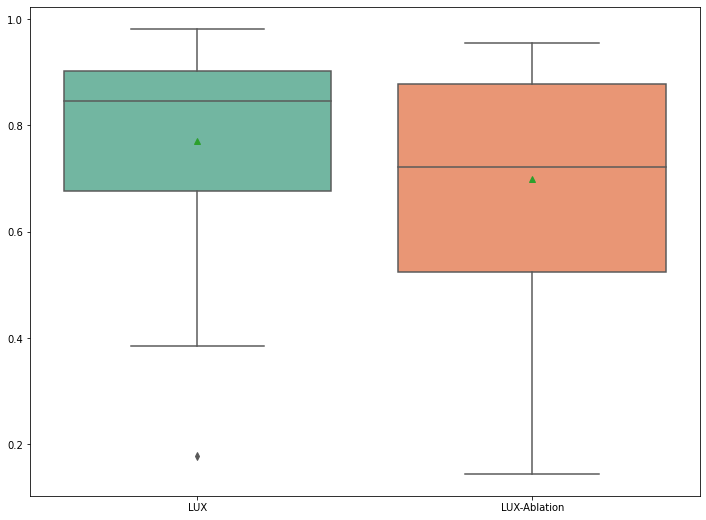

In [360]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import f

file_paths = [f'./results/{d}/synthx100_local_fid.csv' for d in dirs]

#aggregated, aggregated_std,raw = plot_stats_comparison(file_paths,columns=['f1_shap', 'f1_EXPLAN', 'f1_LORE', 'f1_anchor'])
aggregated, aggregated_std,raw_fid = plot_stats_comparison(file_paths,columns=['f1_shap', 'f1_ablation'],models=['LUX', 'LUX-Ablation'],fillna=0)
aggfid=aggregated


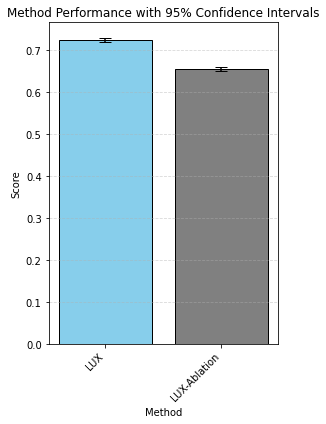

In [361]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_fid.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

## Simplicity

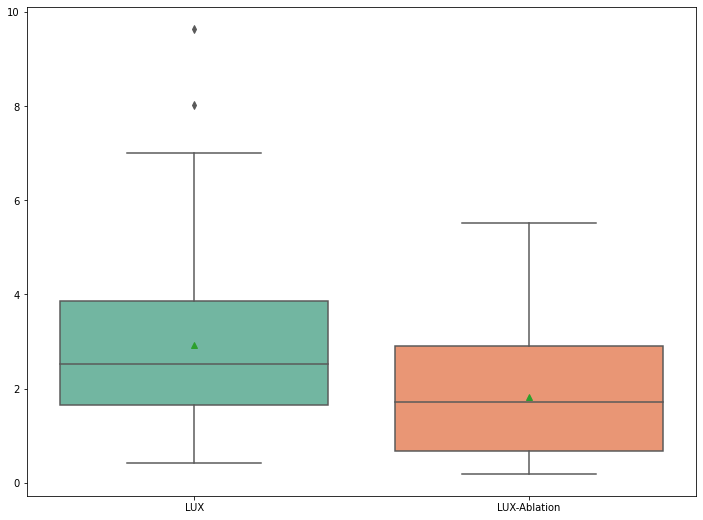

In [362]:



file_paths = [f'./results/{d}/synthx100_rulelen.csv' for d in dirs]

aggregated, aggregated_std,raw_sim = plot_stats_comparison(file_paths, columns=['shap_lux_elen','ablation_lux_elen'],
                                                                          models=['LUX','LUX-Ablation'])
aggsim=aggregated

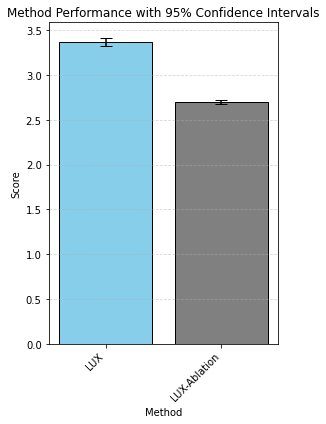

In [363]:
method_cols = ['LUX', 'LUX-Ablation']
raw_sim=raw_sim.fillna(0)
ci_results = compute_method_confidence_intervals(raw_sim[raw_sim!=0], method_columns=method_cols, plot=True, figsize=(4,6))

## Counterfactuals

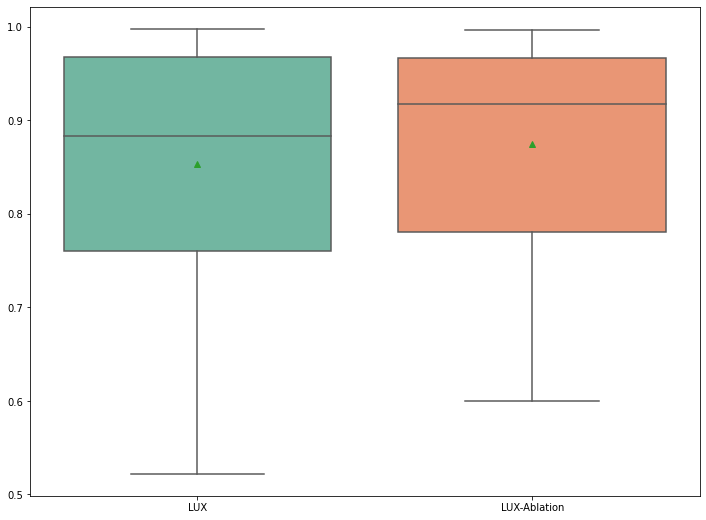

In [364]:
file_paths = [f'./results/{d}/synthx100_scores.csv' for d in dirs]

aggregated, aggregated_std,raw_cf = plot_stats_comparison(file_paths, columns=['f1_score_shap','f1_score_ablation'], models=['LUX','LUX-Ablation'],invalid=0,fillna=0)
aggcf=aggregated

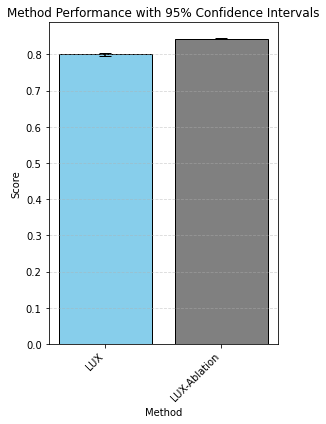

In [365]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_cf.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

## Coverage

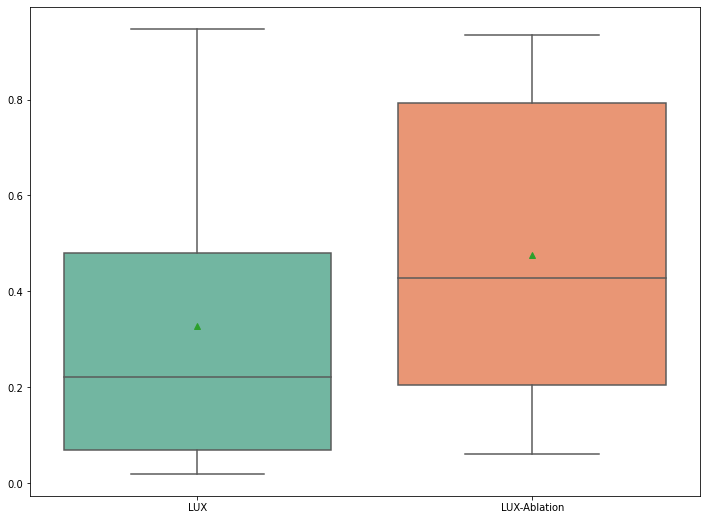

In [366]:


file_paths = [ f'./results/{d}/synthx100_rulecov.csv' for d in dirs]




aggregated, aggregated_std,raw_cov = plot_stats_comparison(file_paths, columns=['cov_shap','cov_ablation'], invalid=0,fillna=0,models=['LUX','LUX-Ablation'])#, models=['LUX','EXPLAN','LORE'])



aggcov=aggregated

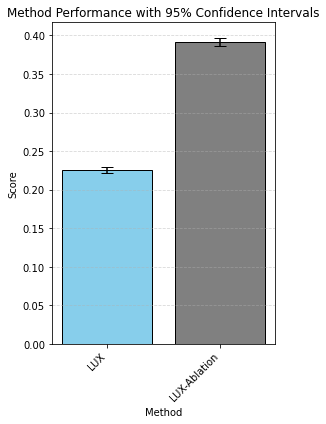

In [367]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_cov.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

## Shap-consistency

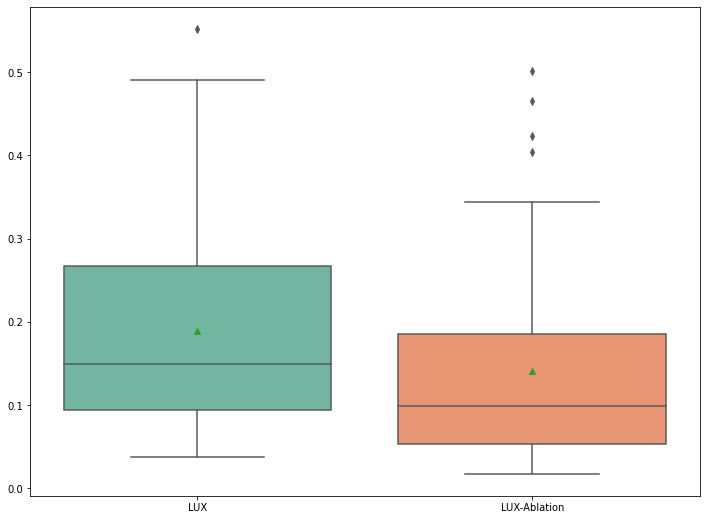

In [368]:



file_paths = [f'./results/{d}/synthx100_importance_gain.csv' for d in dirs]




aggregated, aggregated_std,raw_shap = plot_stats_comparison(file_paths, columns=['importance_gain_shap','importance_gain_ablation'], models=['LUX','LUX-Ablation'],invalid=0,fillna=0)
aggconsist_shap = aggregated

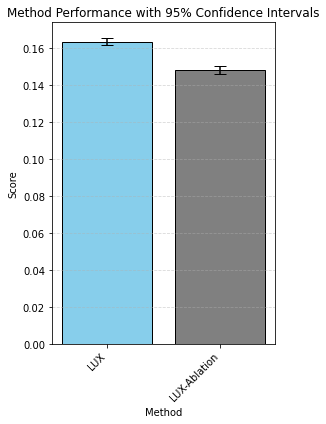

In [369]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_shap.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

## Hits

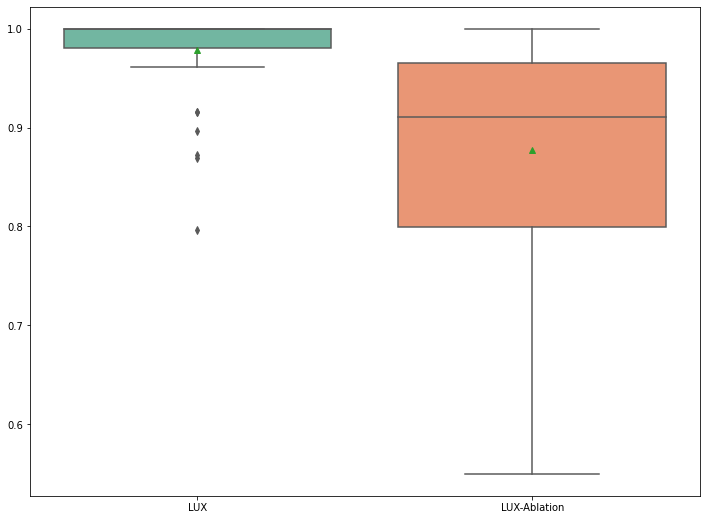

In [371]:
file_paths = [ f'./results/{d}/synthx100_hits.csv' for d in dirs]




aggregated, aggregated_std,raw_hits = plot_stats_comparison(file_paths, columns=['hits_lux_shap', 'hits_lux_ablation'],invalid=0,fillna=0, models=['LUX','LUX-Ablation'])

agghits = aggregated

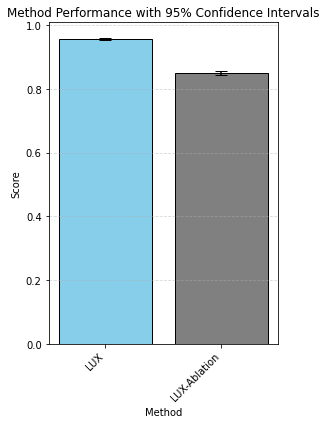

In [372]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_hits.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

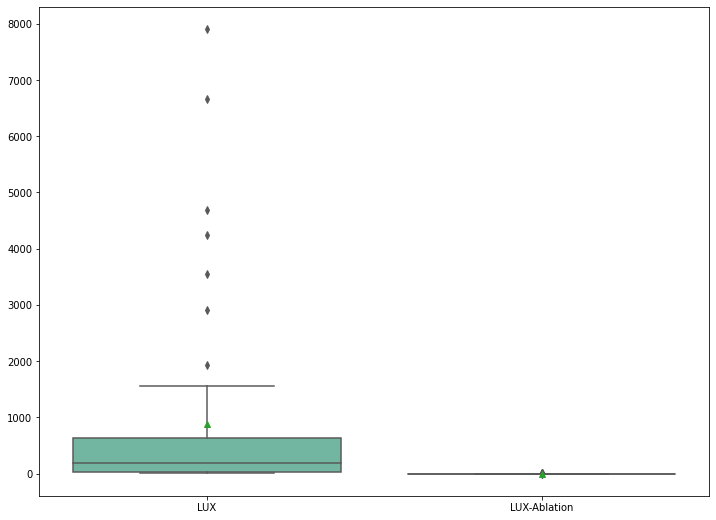

In [373]:
file_paths = [ f'./results/{d}/synthx100_times.csv' for d in dirs]




aggregated, aggregated_std,raw_times = plot_stats_comparison(file_paths, columns=['time_lux_shap','time_lux_ablation'],invalid=0,fillna=0, models=['LUX','LUX-Ablation'])

aggtime = aggregated

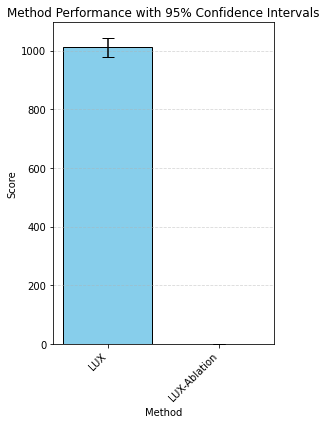

In [374]:
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_times.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6))

## Confidence intervals

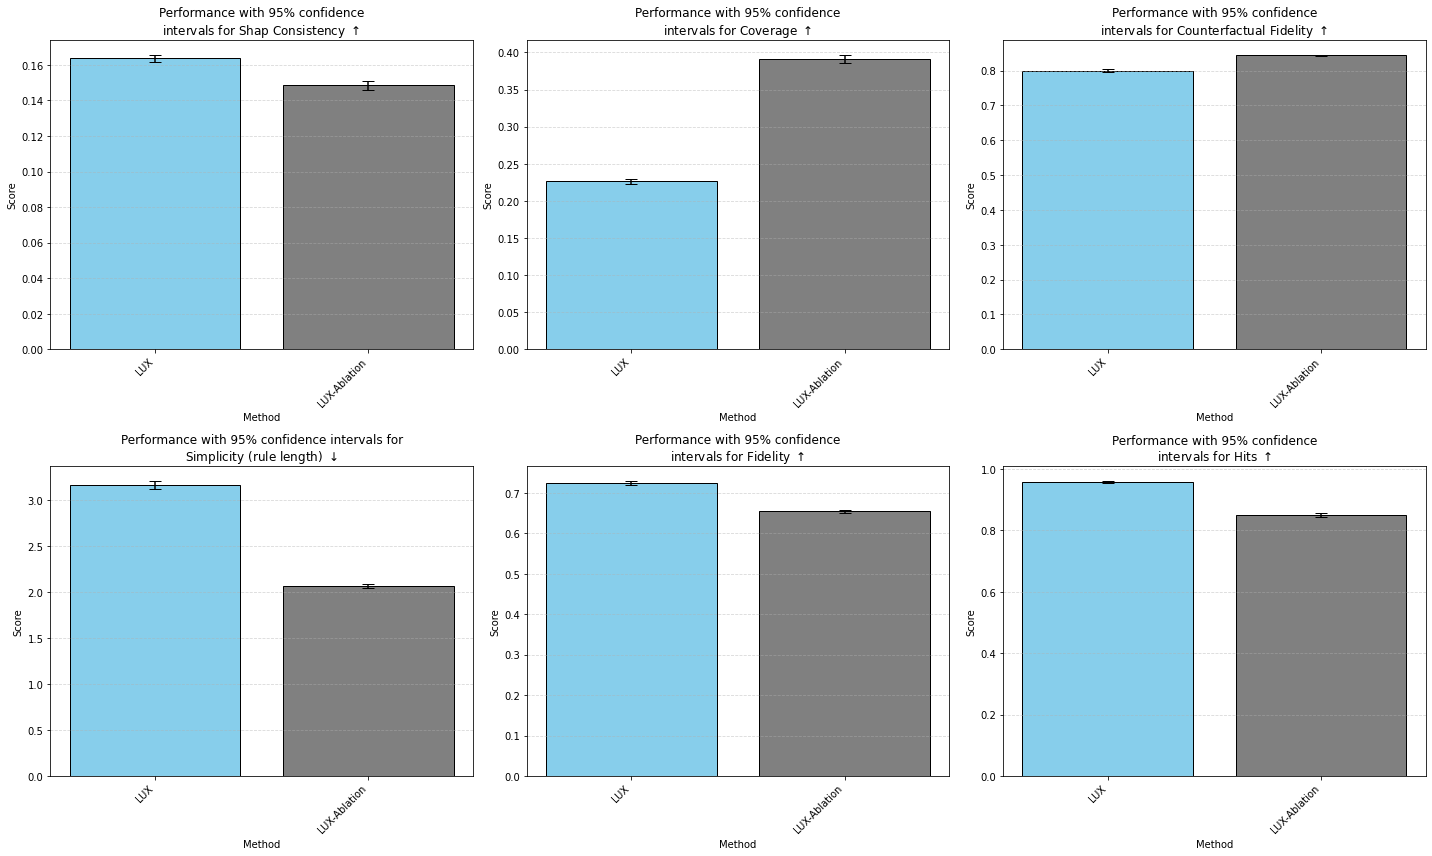

In [375]:
fig, axs = plt.subplots(2,3, figsize=(20,12))
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_shap.fillna(0), method_columns=method_cols, plot=True, figsize=(2,3),ax=axs[0,0],
                                                 title='Performance with 95% confidence\nintervals for Shap Consistency $\\uparrow$')
# method_cols = ['LUX', 'LUX-Ablation']
# ci_results = compute_method_confidence_intervals(raw_pb.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,1],
#                                                  title='Performance with 95% confidence intervals for\nRepresentativeness')
# method_cols = ['LUX', 'LUX-Ablation']
# ci_results = compute_method_confidence_intervals(instance_consistency_data.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,2],
#                                                  title='Performance with 95% confidence intervals for\nStability')
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_cov.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,1],
                                                 title='Performance with 95% confidence\nintervals for Coverage $\\uparrow$')
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_cf.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[0,2],
                                                 title='Performance with 95% confidence\nintervals for Counterfactual Fidelity $\\uparrow$')
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_sim, method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,0],
                                                   title='Performance with 95% confidence intervals for\nSimplicity (rule length) $\\downarrow$')
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_fid.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,1],
                                                 title='Performance with 95% confidence\nintervals for Fidelity $\\uparrow$')
method_cols = ['LUX', 'LUX-Ablation']
ci_results = compute_method_confidence_intervals(raw_hits.fillna(0), method_columns=method_cols, plot=True, figsize=(4,6),ax=axs[1,2],
                                                 title='Performance with 95% confidence\nintervals for Hits $\\uparrow$')
plt.tight_layout()

plt.savefig('./pix/average-performance-ablation.pdf', format='pdf',bbox_inches='tight')

In [376]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel

def test_lux_vs_ablation(df):
    """
    Perform statistical tests comparing LUX and LUX-Ablation paired samples.

    Args:
        df (pd.DataFrame): DataFrame with columns 'LUX' and 'LUX-Ablation'

    Returns:
        dict: p-values of Wilcoxon signed-rank test and paired t-test
    """
    # Extract paired samples
    lux = df['LUX']
    lux_ablation = df['LUX-Ablation']
    
    # Wilcoxon signed-rank test (non-parametric)
    wilcoxon_stat, wilcoxon_p = wilcoxon(lux, lux_ablation)
    
    # Paired t-test (parametric)
    t_stat, t_p = ttest_rel(lux, lux_ablation)
    
    return {
        'wilcoxon_p_value': wilcoxon_p,
        't_test_p_value': t_p
    }


In [377]:
import pandas as pd
from scipy.stats import wilcoxon, ttest_rel
from typing import Union, List

def test_lux_vs_ablation_multi(dfs: Union[pd.DataFrame, List[pd.DataFrame]],
                               names: List[str] = None) -> pd.DataFrame:
    """
    Perform Wilcoxon signed-rank and paired t-tests comparing LUX and LUX-Ablation
    for one or multiple DataFrames. Prints conclusions and returns summary table.

    Args:
        dfs (pd.DataFrame or list of pd.DataFrame): DataFrame(s) with columns 'LUX' and 'LUX-Ablation'
        names (list of str, optional): Names for each DataFrame, default provided

    Returns:
        pd.DataFrame: Summary table with test statistics and p-values
    """
    default_names = [
        "Shap Consistency",
        "Coverage",
        "Counterfactual Fidelity",
        "Simplicity",
        "Fidelity",
        "Hits"
    ]
    
    # Normalize dfs and names to lists
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
    if names is None:
        names = default_names[:len(dfs)]
    elif len(names) != len(dfs):
        raise ValueError("Length of names must match number of DataFrames")
    
    results = []
    
    for df, name in zip(dfs, names):
        lux = df['LUX']
        lux_ablation = df['LUX-Ablation']
        
        # Wilcoxon test
        wilcoxon_stat, wilcoxon_p = wilcoxon(lux, lux_ablation)
        
        # Paired t-test
        t_stat, t_p = ttest_rel(lux, lux_ablation)
        
        # Print conclusion for Wilcoxon
        if wilcoxon_p < 0.05:
            print(f"[{name}] Wilcoxon test: p = {wilcoxon_p:.2e} → **Significant difference detected**")
        else:
            print(f"[{name}] Wilcoxon test: p = {wilcoxon_p:.2e} → No significant difference")
        
        # Print conclusion for paired t-test
        if t_p < 0.05:
            print(f"[{name}] Paired t-test: p = {t_p:.2e} → **Significant difference detected**")
        else:
            print(f"[{name}] Paired t-test: p = {t_p:.2e} → No significant difference")
        
        results.append({
            "Metric": name,
            "Wilcoxon p-value": wilcoxon_p,
            "Paired t-test p-value": t_p
        })
    
    return pd.DataFrame(results)


In [378]:
resdf = test_lux_vs_ablation_multi([raw_shap.fillna(0),raw_cov,raw_cf,raw_fid,raw_hits])

[Shap Consistency] Wilcoxon test: p = 2.02e-55 → **Significant difference detected**
[Shap Consistency] Paired t-test: p = 3.04e-44 → **Significant difference detected**
[Coverage] Wilcoxon test: p = 0.00e+00 → **Significant difference detected**
[Coverage] Paired t-test: p = 0.00e+00 → **Significant difference detected**
[Counterfactual Fidelity] Wilcoxon test: p = 1.85e-184 → **Significant difference detected**
[Counterfactual Fidelity] Paired t-test: p = 7.33e-227 → **Significant difference detected**
[Simplicity] Wilcoxon test: p = 0.00e+00 → **Significant difference detected**
[Simplicity] Paired t-test: p = 1.99e-178 → **Significant difference detected**
[Fidelity] Wilcoxon test: p = 2.03e-278 → **Significant difference detected**
[Fidelity] Paired t-test: p = 3.49e-288 → **Significant difference detected**


In [379]:
resdf

,Metric,Wilcoxon p-value,Paired t-test p-value
0,Shap Consistency,2.022879e-55,3.036967e-44
1,Coverage,0.000000e+00,0.000000e+00
2,Counterfactual Fidelity,1.845778e-184,7.327696e-227
3,Simplicity,0.000000e+00,1.986763e-178
4,Fidelity,2.026841e-278,3.489421e-288


In [380]:
to_latex_nostd(resdf.set_index('Metric'), index_name='Metric')

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|}
\hline
Metric & Wilcoxon p-value&Paired t-test p-value
\\ \hline \hline
Shap Consistency & 0.00 & 0.00\\ \hline
Coverage & 0.00 & 0.00\\ \hline
Counterfactual Fidelity & 0.00 & 0.00\\ \hline
Simplicity & 0.00 & 0.00\\ \hline
Fidelity & 0.00 & 0.00\\ \hline
\end{tabularx}
\end{table}
